Originaldaten geladen: 35137 Einträge
        Datum Zeitzone    von    bis Einheit  Deutschland
0  01.01.2024      CET  00:00  00:15      MW       47.876
1  01.01.2024      CET  00:15  00:30      MW      426.424
2  01.01.2024      CET  00:30  00:45      MW      975.596
3  01.01.2024      CET  00:45  01:00      MW      718.820
4  01.01.2024      CET  01:00  01:15      MW      257.764
Interpolierte Daten erstellt: 105408 Einträge
                Datum Zeitzone    von    bis Einheit    Saldo  Jahr  KW
0 2024-01-01 00:00:00      CET  00:00  00:05      MW   47.876  2024   1
1 2024-01-01 00:05:00      CET  00:05  00:10      MW  135.199  2024   1
2 2024-01-01 00:10:00      CET  00:10  00:15      MW  261.382  2024   1
3 2024-01-01 00:15:00      CET  00:15  00:20      MW  426.424  2024   1
4 2024-01-01 00:20:00      CET  00:20  00:25      MW  630.326  2024   1
Interpolierte Daten in /Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_nrv/NRV-Saldo_2024_5min_quadr

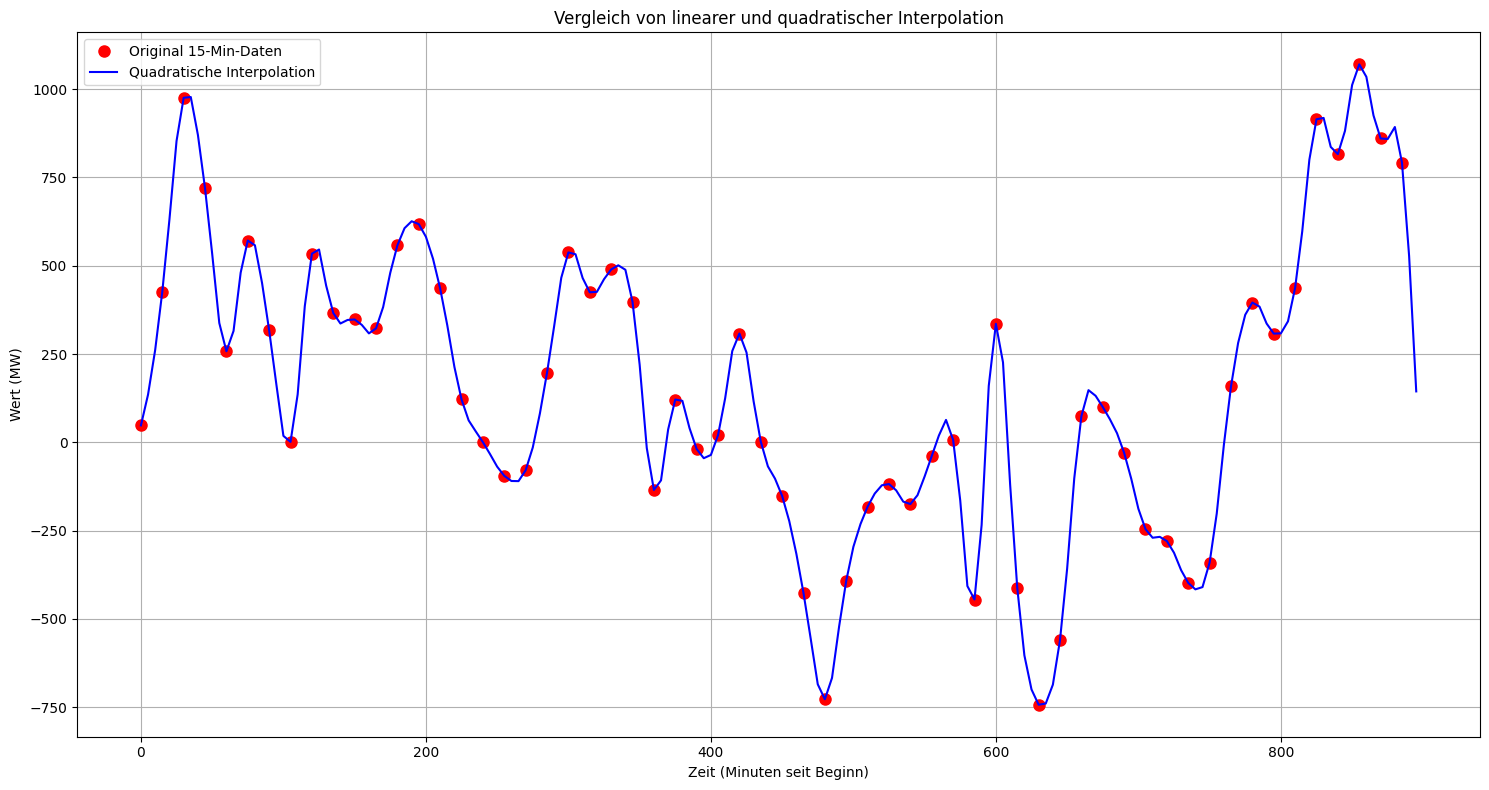

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import interpolate

# 1. CSV-Datei importieren
def load_and_interpolate_data(input_file, output_file, method='quadratic'):
    # Datei einlesen
    df = pd.read_csv(input_file, sep=';', decimal=',')
    print(f"Originaldaten geladen: {len(df)} Einträge")
    print(df.head())
    
    # DataFrame für interpolierte Daten vorbereiten
    df_interpolated = []
    
    # Werte für Interpolation vorbereiten
    values = df['Deutschland'].values
    
    # Für quadratische Interpolation mindestens 3 Punkte benötigt
    if len(values) < 3:
        print("Zu wenige Datenpunkte für quadratische Interpolation!")
        return
    
    # X-Werte (Zeitpunkte) für die 15-Minuten-Intervalle
    x_orig = np.arange(0, len(values) * 15, 15)
    
    # X-Werte für die 5-Minuten-Intervalle
    x_new = np.arange(0, (len(values) - 1) * 15 + 1, 5)
    
    # Quadratische Interpolation durchführen
    if method == 'quadratic':
        f = interpolate.interp1d(x_orig, values, kind='quadratic', bounds_error=False, fill_value="extrapolate")
    else:
        f = interpolate.interp1d(x_orig, values, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Neue Y-Werte berechnen
    y_new = f(x_new)
    
    # Über jeden 5-Minuten-Zeitpunkt iterieren
    for i in range(len(x_new)):
        # Index des vorherigen 15-Minuten-Blocks
        orig_idx = i // 3
        if orig_idx >= len(df):
            break
            
        # Aktuellen Datenpunkt aus Originaldaten holen
        row = df.iloc[orig_idx]
        current_date = row['Datum']
        current_timezone = row['Zeitzone']
        current_unit = row['Einheit']
        
        # Zeitpunkte berechnen
        dt_start = datetime.strptime(f"{current_date} {row['von']}", "%d.%m.%Y %H:%M")
        additional_minutes = (i % 3) * 5
        
        time_from = dt_start + timedelta(minutes=additional_minutes)
        time_to = time_from + timedelta(minutes=5)
        
        # Datenpunkt hinzufügen
        df_interpolated.append({
            'Datum': pd.to_datetime(f"{current_date} {time_from.strftime('%H:%M')}", format="%d.%m.%Y %H:%M"),
            'Zeitzone': current_timezone,
            'von': time_from.strftime("%H:%M"),
            'bis': time_to.strftime("%H:%M"),
            'Einheit': current_unit,
            'Saldo': round(y_new[i], 3)
        })
        
    # Lösche die letzte Spalte
    df_interpolated = df_interpolated[:-1]
    
    # In DataFrame umwandeln
    result_df = pd.DataFrame(df_interpolated)
        
    # Kalenderwoche berechnen
    result_df['Jahr'] = result_df['Datum'].dt.year
    result_df['KW'] = result_df['Datum'].dt.isocalendar().week
    
    result_df.loc[(result_df['KW'] == 1) & (result_df['Datum'].dt.month == 12), 'KW'] = 53
    
    
    print(f"Interpolierte Daten erstellt: {len(result_df)} Einträge")
    print(result_df.head())
    
    # 3. In CSV-Datei speichern
    result_df.to_csv(output_file, sep=';', decimal=',', index=False)
    print(f"Interpolierte Daten in {output_file} gespeichert.")
    
    return result_df, y_new, x_new

# Pfade festlegen
input_file = "/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_nrv/NRV-Saldo_2024.csv"
output_file_quadratic = "/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_nrv/NRV-Saldo_2024_5min_quadratic.csv"

# Funktionen aufrufen
df_quad, y_quad, x_quad = load_and_interpolate_data(input_file, output_file_quadratic, method='quadratic')

# Zum Vergleich auch lineare Interpolation durchführen
# output_file_linear = "/Users/davidsanders/Documents/GitHub/masterarbeit-flex-kpis/input/datenaufbereitung_nrv/NRV-Saldo_2024_5min_linear.csv"
# df_lin, y_lin, x_lin = load_and_interpolate_data(input_file, output_file_linear, method='linear')

# Visualisierung beider Methoden zum Vergleich
import matplotlib.pyplot as plt

# Originaldaten
df_orig = pd.read_csv(input_file, sep=';', decimal=',')
x_orig = np.arange(0, len(df_orig) * 15, 15)[:60]  # Erste 15 15-Minuten-Intervalle
y_orig = df_orig['Deutschland'].values[:60]

plt.figure(figsize=(15, 8))

# Plot der ersten 60 Datenpunkte zum besseren Vergleich
plt.plot(x_orig, y_orig, 'ro', label='Original 15-Min-Daten', markersize=8)
plt.plot(x_quad[:180], y_quad[:180], 'b-', label='Quadratische Interpolation', markersize=5)

plt.title('Vergleich von linearer und quadratischer Interpolation')
plt.xlabel('Zeit (Minuten seit Beginn)')
plt.ylabel('Wert (MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
df_quad

,Datum,Zeitzone,von,bis,Einheit,Saldo,Jahr,KW
0,2024-01-01 00:00:00,CET,00:00,00:05,MW,47.876,2024,1
1,2024-01-01 00:05:00,CET,00:05,00:10,MW,135.199,2024,1
2,2024-01-01 00:10:00,CET,00:10,00:15,MW,261.382,2024,1
3,2024-01-01 00:15:00,CET,00:15,00:20,MW,426.424,2024,1
4,2024-01-01 00:20:00,CET,00:20,00:25,MW,630.326,2024,1
...,...,...,...,...,...,...,...,...
105403,2024-12-31 23:35:00,CET,23:35,23:40,MW,787.644,2024,53
105404,2024-12-31 23:40:00,CET,23:40,23:45,MW,846.675,2024,53
105405,2024-12-31 23:45:00,CET,23:45,23:50,MW,887.368,2024,53
105406,2024-12-31 23:50:00,CET,23:50,23:55,MW,907.715,2024,53


In [16]:
60*24*366/5

105408.0